# Selective withdrawal overzicht

In [42]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', **{'size': 15})
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
import scipy
from scipy import stats
from scipy.optimize import fsolve, root, curve_fit
import csv
import pandas as pd
from IPython.display import Image
import progressbar
import os
import uncertainties.unumpy as unp
import uncertainties as unc

In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def inch2m(inch):
    return inch * 0.0254

def m2inch(m):
    return m/0.0254

def loadcsvfile(filename, path='data/', delimiter=';'):
    exceldata = pd.read_excel(path+filename)
    exceldata.to_csv(path+'csv/'+filename[:-5]+'.csv', sep=delimiter, index=None, header=True)
    csvdata = pd.read_csv(path+'csv/'+filename[:-5]+'.csv', delimiter=delimiter)
    csvdata = csvdata.iloc[1:]
    csvdata.index -= 1
    for key in csvdata:
        if key != 'experiment':
            csvdata[key] = csvdata[key].astype('float')
    return csvdata

### Data van verschillende papers

In [32]:
# Harleman & Elder
HaEl1 = loadcsvfile('Harleman_Elder_1.xlsx')
HaEl2 = loadcsvfile('Harleman_Elder_2.xlsx')
# Noordland proeven (M1204)
NL1204 = loadcsvfile('Noordland_M1204.xlsx')
NL1204['h0'] = NL1204.am
NL1204.loc[~np.isnan(NL1204['as']), 'h0'] = NL1204.loc[~np.isnan(NL1204['as']), 'as']
#Noordland referentieproeven met delta_rho = 2
sel = np.arange(47)
NL1204ref = NL1204.iloc[sel]

# IJmuiden paper
IJ = loadcsvfile('IJmuiden.xlsx')

Yu = loadcsvfile('Yu.xlsx')

In [4]:
NL1204D3Q1 = NL1204ref[(NL1204ref.Q==1e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q2 = NL1204ref[(NL1204ref.Q==2e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q3 = NL1204ref[(NL1204ref.Q==3e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q4 = NL1204ref[(NL1204ref.Q==4e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q5 = NL1204ref[(NL1204ref.Q==5e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q6 = NL1204ref[(NL1204ref.Q==6e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q7 = NL1204ref[(NL1204ref.Q==7e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q8 = NL1204ref[(NL1204ref.Q==8e-3) & (NL1204ref.D==3.1e-2)]

NL1204D6Q1 = NL1204ref[(NL1204ref.Q==1e-3) & (NL1204ref.D==6.1e-2)]
NL1204D6Q2 = NL1204ref[(NL1204ref.Q==2e-3) & (NL1204ref.D==6.1e-2)]
NL1204D6Q3 = NL1204ref[(NL1204ref.Q==3e-3) & (NL1204ref.D==6.1e-2)]
NL1204D6Q5 = NL1204ref[(NL1204ref.Q==5e-3) & (NL1204ref.D==6.1e-2)]

reference_data = [NL1204D3Q1,NL1204D3Q3,NL1204D3Q5,NL1204D3Q7,
                  NL1204D6Q1,NL1204D6Q3,NL1204D6Q5]

### Constantes

In [5]:
g = 9.81 # [m s^-2] gravitatieversnelling
rho_1 = 1000 # [kg m^-3] dichtheid zoet water
rho_2 = 1022 # [kg m^-3] dichtheid zout water
Drho = rho_2 - rho_1 # [kg m^-3] dichtheidsverschil
eps = Drho/rho_2
gp = eps*g

### Height of layers

In [6]:
H_T = 1
H2 = 0.5
H1 = H_T - H2

### Equations Islam et al. (2018)

$$F_r = \frac{q}{\sqrt{g'H_2^3}}$$\
$$F_1^2 = \frac{q_1^2}{g'h_1^3}$$\
$$F_2^2 = \frac{q_2^2}{g'h_2^3}$$\
$$F_1^2 = \left( 1-\epsilon F_1^2 \right)\left( 1-F_2^2 \right)$$\
$$\epsilon F_1^2 = \frac{H_1}{h_1} + \frac{H_2}{h_1} - \frac{h_2}{h_1} - 1$$\
$$\frac{1}{2}F_2^2 - \frac{1}{2}F_1^2 \frac{h_1}{h_2} + 1 = \frac{H_2}{h_2}$$\
The values for $F_2^2$, $h_1$, $h_2$, $q_1$ and $q_2$ can be calculated for any given values of $F_1^2$, $H_1$ and $H_2$.

Using above equations, this gives: \
$$F_2^2 = 1 - \frac{F_1^2}{1-\epsilon F_1^2}$$ \
$$h_2 = \frac{F_1^2\left(H_2+H_1+2H_2\epsilon\right)+2H_2}{F_1^2\left(1+\epsilon\left(F_2^2+2\right)\right)+F_2^2+2}$$ \
$$h_1 = \frac{H_1\left(2+F_2^2\right)+H_2 F_2^2}{2+F_2^2+F_1^2\left(1+\epsilon\left(2+F_2^2\right)\right)}$$\
$$q_1 = \sqrt{F_1^2 g' h_1^3}$$\
$$q_2 = \sqrt{F_2^2 g' h_2^3}$$

from which $\lambda$ and the Froude number $F_r$ can be found:\
$$\lambda = \frac{q_1}{q} = \frac{q_1}{q_1+q_2}$$\
$$F_r = \sqrt{\frac{q^2}{g'H_2^3}} = \sqrt{\frac{\left(q_1+q_2\right)^2}{g'H_2^3}}$$

In [7]:
def solveIslam(F1s,H1=H1,H2=H2):
    #F2s = 1-F1s/(1-eps*F1s)
    #h2 = ( F1s*(H2+H1+2*H2*eps)+2*H2 ) / ( F1s*(1+eps*(F2s+2))+F2s+2 )
    #h1 = ( H1*(2+F2s)+H2*F2s ) / ( 2+F2s+F1s*(1+eps*(2+F2s)) )
    F2s = 1-F1s
    h2 = ( F1s*(H2+H1)+2*H2 ) / ( F1s+F2s+2 )
    h1 = ( H1*(2+F2s)+H2*F2s ) / ( 2+F2s+F1s )
    q1 = np.sqrt(F1s*gp*h1**3)
    q2 = np.sqrt(F2s*gp*h2**3)
    lam = q1/(q1+q2)
    Fr = (q1+q2)/np.sqrt(gp*H2**3)
    return F2s, h1, h2, q1, q2, lam, Fr

### Incipient case: 
$q_1 = 0 \rightarrow F_1^2 = 0$ \
From the above equations, this gives: \
$F_2^2 = 1$\
$h_2 = \frac{2}{3}H_2$\
$h_1 = H_1 + \frac{H_2}{3}$\
$\lambda = 0$\
$F_r = \left(\frac{2}{3}\right)^{\frac{3}{2}} \approx 0.544$

In [8]:
incipient = solveIslam(F1s=0)
print(r'F2s={0}, h1={1}, h2={2}'.format(incipient[0],incipient[1],incipient[2]))
print(r'q1={0}, q2={1}, lam={2}, Fr={3}'.format(incipient[3],incipient[4],incipient[5],incipient[6]))

F2s=1, h1=0.6666666666666666, h2=0.3333333333333333
q1=0.0, q2=0.08843791886118967, lam=0.0, Fr=0.5443310539518172


### Maximum selective withdrawal (for $H_2/H_T = 0.5$):
$F_1^2 = 0.5$\
Using above equations, this gives:

In [9]:
selective_max = solveIslam(F1s=0.5)
print(r'F2s={0}, h1={1}, h2={2}'.format(selective_max[0],selective_max[1],selective_max[2]))
print(r'q1={0}, q2={1}, lam={2}, Fr={3}'.format(selective_max[3],selective_max[4],selective_max[5],selective_max[6]))

F2s=0.5, h1=0.5, h2=0.5
q1=0.11488422658742582, q2=0.11488422658742582, lam=0.5, Fr=1.4142135623730951


### Now for all values between $0\leq F_1^2 \leq 0.5$ (for $H_2/H_T = 0.5$):

In [10]:
F1s_arr = np.linspace(0,1,500000)
f = pd.DataFrame({'F1s': F1s_arr,
                  'F2s': np.zeros(len(F1s_arr)),
                  'h1': np.zeros(len(F1s_arr)),
                  'h2': np.zeros(len(F1s_arr)),
                  'q1': np.zeros(len(F1s_arr)),
                  'q2': np.zeros(len(F1s_arr)),
                  'Fr': np.zeros(len(F1s_arr)),
                  'lam': np.zeros(len(F1s_arr))})

sol = solveIslam(F1s_arr, H1=H1, H2=H2)
f.F2s, f.h1, f.h2, f.q1, f.q2, f.lam, f.Fr = sol

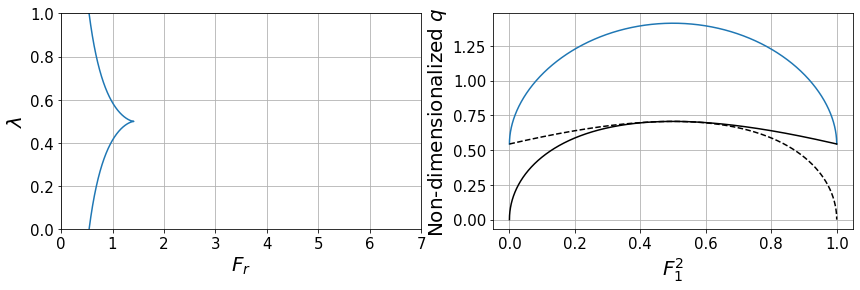

In [11]:
figprops = dict(figsize=(10, 6), dpi=72)
fig = plt.figure(**figprops)

ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel='$F_r$', ylabel='$\lambda$', title='')
ax.axis([0,7,0,1])
ax.grid()
ax.plot(f.Fr, f.lam)

bx = plt.axes([0.6, 0, .5, .5])
bx.set(xlabel='$F_1^2$', ylabel='Non-dimensionalized $q$', title='')
bx.grid()
bx.plot(f.F1s, f.Fr)
bx.plot(f.F1s, f.q1/np.sqrt(gp*H2**3), 'k')
bx.plot(f.F1s, f.q2/np.sqrt(gp*H2**3), '--k')

plt.show()

### Now recreate Jirka figure 3
In Jirka, for a given $H_2/H_T$, $F_{r_{max}}$ can be calculated (NOTE: this is for very small $\epsilon$ and $F_1$) by\
$F_{r_{max}} = \left( \frac{H}{H_2} \right)^{5/2} \left( 1+\sqrt{\frac{H}{H_2}-1} \right)^{-2}$

In [12]:
def Frmax_func(H2, H):
    return pow(H/H2, 5/2) * pow(1+np.sqrt(H/H2-1),-2)

In [13]:
ff = pd.DataFrame({})

H2_arr = np.array([0.25, 0.375, 0.5, 0.625, 0.75])
F1s_arr = np.linspace(0,1,500000)

for H2 in progressbar.progressbar(H2_arr):
    H1 = H_T - H2
    f = pd.DataFrame({'F1s': F1s_arr,
                      'F2s': np.zeros(len(F1s_arr)),
                      'h1': np.zeros(len(F1s_arr)),
                      'h2': np.zeros(len(F1s_arr)),
                      'q1': np.zeros(len(F1s_arr)),
                      'q2': np.zeros(len(F1s_arr)),
                      'Fr': np.zeros(len(F1s_arr)),
                      'lam': np.zeros(len(F1s_arr)),
                      'H2': np.ones(len(F1s_arr))*H2})

    sol = solveIslam(F1s_arr, H1=H1, H2=H2)
    f.F2s, f.h1, f.h2, f.q1, f.q2, f.lam, f.Fr = sol
    # Finding max lambda:
    iF = np.where(f.Fr==max(f.Fr))[0][0]
    lammax = f.lam[iF]
    
    # Forcing max lambda:
    #lammax = 1-H2/H_T
    #Frmax = Frmax_func(H2=H2, H=H_T)
    #iF = np.where(f.lam>=lammax)[0][0]
    
    f = f[:iF]
    f = f.append({'Fr': 100, 'lam': lammax, 'H2': H2}, ignore_index=True)
    ff = ff.append(f)

100% (5 of 5) |##########################| Elapsed Time: 0:00:01 Time:  0:00:01


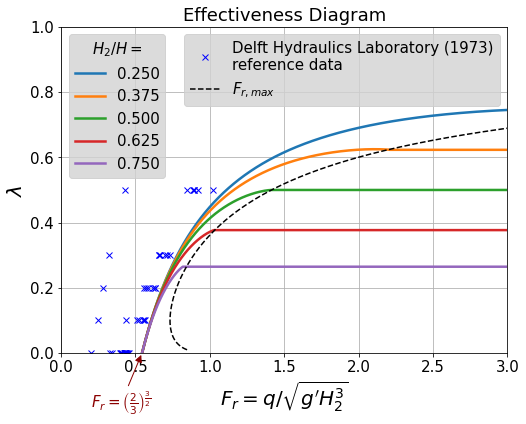

In [14]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.set(xlabel="$F_r=q/\sqrt{g'H_2^3}$", ylabel='$\lambda$', title='Effectiveness Diagram')
ax.axis([0,3,0,1])
ax.grid()
[ax.plot(ff.Fr[ff.H2==H2], ff.lam[ff.H2==H2], linewidth=2.5, label="{0:.3f}".format(H2/H_T)) for H2 in H2_arr]

lam_arr = np.linspace(0.01,0.9,1000)
Frmax = pow(1-lam_arr, -5/2)*pow(1+np.sqrt(lam_arr/(1-lam_arr)),-2)
Frmaxplot, = ax.plot(Frmax, lam_arr, '--k')
leg1 = ax.legend(loc="upper left", title="$H_2/H=$", facecolor="lightgray")

NLplot, = ax.plot(NL1204ref.Fr, NL1204ref.lam, 'xb')
leg2 = ax.legend([NLplot, Frmaxplot], ["Delft Hydraulics Laboratory (1973)\nreference data", r"$F_{r,max}$"], loc='upper right', facecolor="lightgray")
ax.add_artist(leg1)

ax.annotate(r"$F_r = \left(\frac{2}{3}\right)^{\frac{3}{2}}$", color='darkred', xy=(0.544,0), xytext=(0.2, -.17),
            arrowprops=dict(arrowstyle="-|>", color='darkred'))

plt.show()
#plt.savefig("figures/Jirka_fig3_effectiveness_diagram.png", bbox_inches='tight')

# Constant to account for friction

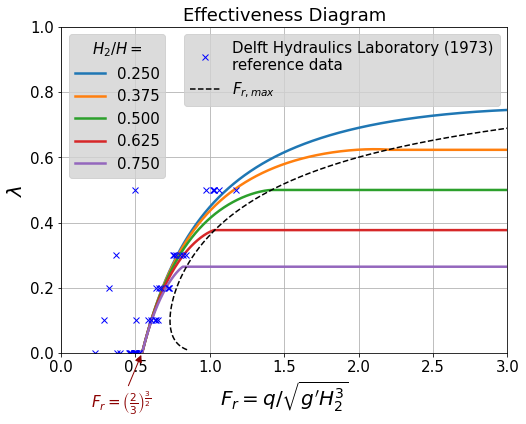

In [15]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.set(xlabel="$F_r=q/\sqrt{g'H_2^3}$", ylabel='$\lambda$', title='Effectiveness Diagram')
ax.axis([0,3,0,1])
ax.grid()
[ax.plot(ff.Fr[ff.H2==H2], ff.lam[ff.H2==H2], linewidth=2.5, label="{0:.3f}".format(H2/H_T)) for H2 in H2_arr]

lam_arr = np.linspace(0.01,0.9,1000)
Frmax = pow(1-lam_arr, -5/2)*pow(1+np.sqrt(lam_arr/(1-lam_arr)),-2)
Frmaxplot, = ax.plot(Frmax, lam_arr, '--k')
leg1 = ax.legend(loc="upper left", title="$H_2/H=$", facecolor="lightgray")

beta = np.sqrt(1.33)
NLplot, = ax.plot(beta*NL1204ref.Fr, NL1204ref.lam, 'xb')
leg2 = ax.legend([NLplot, Frmaxplot], ["Delft Hydraulics Laboratory (1973)\nreference data", r"$F_{r,max}$"], loc='upper right', facecolor="lightgray")
ax.add_artist(leg1)

ax.annotate(r"$F_r = \left(\frac{2}{3}\right)^{\frac{3}{2}}$", color='darkred', xy=(0.544,0), xytext=(0.2, -.17),
            arrowprops=dict(arrowstyle="-|>", color='darkred'))

#NLsel = NL1204[(NL1204.D<2/3*NL1204.hr) & (0.36/NL1204.hr>3) & (0.36/NL1204.hr<6)]
#ax.plot(NLsel.Fr, NLsel.lam, 'or')

plt.show()
#plt.savefig("figures/Jirka_fig3_effectiveness_diagram.png", bbox_inches='tight')

# Fan

Fan stappenplan:
1) $K$ estimated according to outlet type ($K\approx1.5$ for bottom slot) and $P$ determined/obtained;
2) $h_L$ obtained through $K=Gh_L=g'^{\frac{1}{3}}h_L/q^{\frac{2}{3}}$, with $G=g'^{1/3}/q^{2/3}$ and $y=P-h_0$ from measurements;
3) use figure 9 from Fan (2008) to estimate $a$;
4) use $c_0/c_2 = a-bGy$ (or $c_0/c_2 = a'-bGy'$ for $P<h_L$) with $b=1/(2K)$.

Example on the data of Yu (2004 (see paragraph "Description of typical experiments"):\
$C_i=17.3$ g/L $\rightarrow g' \approx 0.17$ m/s$^2$\
$q_0 = 37.67$ cm$^2$/s\
$Z_0/H = 0.4 \rightarrow P = 16.125$ cm\
$K=0.53 \rightarrow b=\frac{1}{2K}=0.94$ (from Fan table I)
$h_L = Kq_0^{\frac{2}{3}}/g'^{\frac{1}{2}} = 9.75$ cm\
$\frac{P}{h_L}-1 = 0.654 \rightarrow a = 0.52$ (from Fan figure 9)\
$\frac{c_0}{c_2} = a - bGy$\
NOTE: in Fan, $y$ is defined positive downwards

In the figure below, the data points of Yu (2004) are plotted as well as the predicted $c_0/c_2$. The predicted line (blue) is not the best fit through the data points. When a linear fit is performed (red line), another value for $b$ is found, i.e. $b=0.78$, which corresponds to $K=0.64$. The values for $a$ remains (approximately) the same.

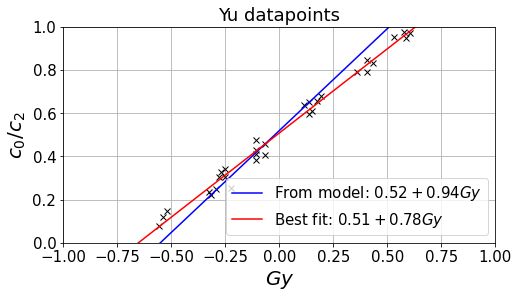

In [17]:
figprops = dict(figsize=(12, 6), dpi=72)
fig = plt.figure(**figprops)

ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title='Yu datapoints')
ax.axis([-1,1,0,1])
ax.grid()

ax.plot(Yu.Gy, Yu.c0_f_c2, 'xk')

a = 0.52
b = 1/(2*0.53)
Gy = np.linspace(-10,10,10000)
c0c2 = a + b*Gy
ax.plot(Gy, c0c2, 'b', label="From model: ${0:.2f} + {1:.2f}Gy$".format(a, b))

p = np.polyfit(Yu.Gy, Yu.c0_f_c2, 1)
ax.plot(Gy, p[0]*Gy + p[1], 'r', label="Best fit: ${0:.2f} + {1:.2f}Gy$".format(p[1], p[0]))

ax.legend()
plt.show()

# Figure 9 of Fan, trendline that I plotted is obtained from WebPlotDigitzer

In [18]:
coeffaSlot = pd.DataFrame({
    'P':      np.array([14,   27,   40 ]),
    'a':      np.array([.67,  .53,  .42]),
    'b':      np.array([.56,  .56,  .56]),
    'G':      np.array([.065, .062, .1 ]),
    'hL':     np.array([13.9, 14.6, 9  ]),
    'P/hL-1': np.array([0.01, 0.85, 3.4])
})

coeffaOrifice = pd.DataFrame({
    'P':      np.array([40, 25, 25, 8, 1]),
    'a':      np.array([.43, .48, .48, .72, .96]),
    'b':      np.array([.48, .48, .48, .48, .58]),
    'G':      np.array([.11, .09, .095, .08, .08]),
    'hL':     np.array([9.5, 11.7, 11.0, 13.1, 13.2]),
    'P/hL-1': np.array([3.19, 1.14, 1.27, -0.39, -0.92])
})

coeffaSanmenxia = pd.DataFrame({
    'P':      np.array([12.3, 13.3, 9.3, 1.4]),
    'a':      np.array([.56, .56, .7, 1.1]),
    'b':      np.array([.56, .56, .56, .56]),
    'G':      np.array([.078, .08, .11, .072]),
    'hL':     np.array([11.5, 11.3, 8.2, 12.2]),
    'P/hL-1': np.array([.07, .17, .13, -.88])
})

coeffaGuanting = pd.DataFrame({
    'P':      np.array([-6.5]),
    'a':      np.array([2]),
    'b':      np.array([1.25]),
    'G':      np.array([0.15]),
    'hL':     np.array([4.3]),
    'P/hL-1': np.array([-2.5])
})

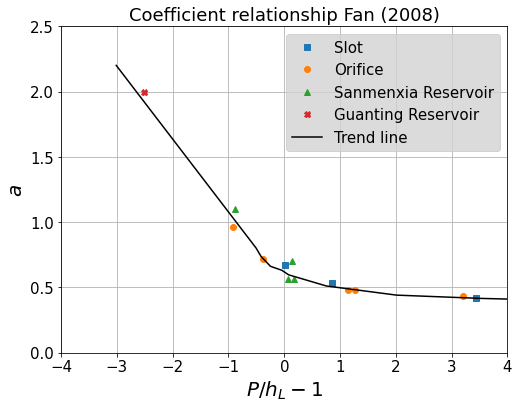

In [20]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set(xlabel=r"$P/h_L-1$", ylabel=r'$a$', title=r"Coefficient relationship Fan (2008)")
ax.axis([-4,4,0,2.5])
ax.grid()

ax.plot(coeffaSlot.P/coeffaSlot.hL-1, coeffaSlot.a, 's', label=r"Slot")
ax.plot(coeffaOrifice.P/coeffaOrifice.hL-1, coeffaOrifice.a, 'o', label=r"Orifice")
ax.plot(coeffaSanmenxia.P/coeffaSanmenxia.hL-1, coeffaSanmenxia.a, '^', label=r"Sanmenxia Reservoir")
ax.plot(coeffaGuanting.P/coeffaGuanting.hL-1, coeffaGuanting.a, 'X', label=r"Guanting Reservoir")

#trendline using webplotdigitizer
trendline_x = [-3.01123595505618, -0.5056179775280905, -0.41573033707865203, -0.24719101123595522,
               -0.0449438202247201, 0.0786516853932584, 0.7528089887640439, 2.011235955056179, 
               3.5168539325842687, 3.988764044943819]
sorttrend = np.argsort
trendline_y = [2.20066889632107, 0.8010033444816052, 0.7357859531772573, 0.6605351170568561,
               0.6304347826086956, 0.595317725752508, 0.5100334448160533, 0.43979933110367897, 
               0.4147157190635449, 0.40969899665551823]
ax.plot(trendline_x, trendline_y,'k', label="Trend line")

plt.legend(loc='upper right', facecolor="lightgray")
#plt.savefig("figures/coefficient_relationship_fan.png", bbox_inches="tight")

# Noordland data

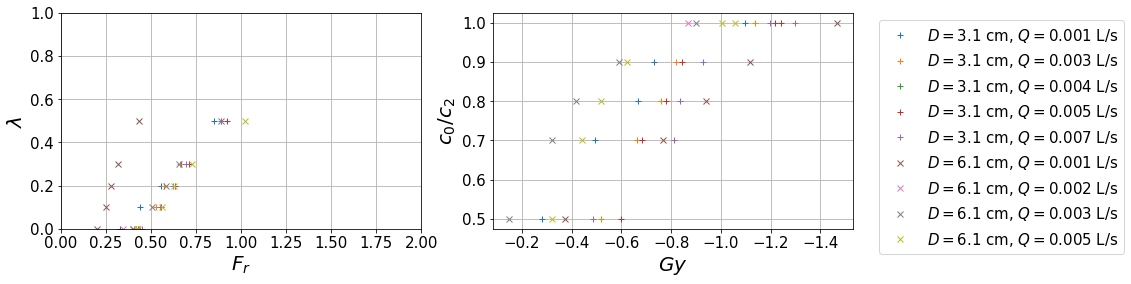

In [38]:
NL1204D3Q1 = NL1204ref[(NL1204ref.Q==1e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q2 = NL1204ref[(NL1204ref.Q==2e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q3 = NL1204ref[(NL1204ref.Q==3e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q4 = NL1204ref[(NL1204ref.Q==4e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q5 = NL1204ref[(NL1204ref.Q==5e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q6 = NL1204ref[(NL1204ref.Q==6e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q7 = NL1204ref[(NL1204ref.Q==7e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q8 = NL1204ref[(NL1204ref.Q==8e-3) & (NL1204ref.D==3.1e-2)]

NL1204D6Q1 = NL1204ref[(NL1204ref.Q==1e-3) & (NL1204ref.D==6.1e-2)]
NL1204D6Q2 = NL1204ref[(NL1204ref.Q==2e-3) & (NL1204ref.D==6.1e-2)]
NL1204D6Q3 = NL1204ref[(NL1204ref.Q==3e-3) & (NL1204ref.D==6.1e-2)]
NL1204D6Q5 = NL1204ref[(NL1204ref.Q==5e-3) & (NL1204ref.D==6.1e-2)]

reference_data = [NL1204D3Q1,NL1204D3Q3,NL1204D3Q5,NL1204D3Q7,
                  NL1204D6Q1,NL1204D6Q3,NL1204D6Q5]
refcol = np.array(['r', 'g', 'b', 'c', 'm', 'y', 'k'])

figprops = dict(figsize=(10, 6), dpi=72)
fig = plt.figure(**figprops)

ax = plt.axes([0, 0, .5, .5])
ax.set(xlabel=r"$F_r$", ylabel=r'$\lambda$', title='')
ax.axis([0,2,0,1])
ax.grid()

ax.plot(NL1204D3Q1.Fr, NL1204D3Q1.lam, '+', label="$D=3.1$ cm, $Q=0.001$ L/s")
#ax.plot(NL1204D3Q2.Fr, NL1204D3Q2.lam, '+', label="$D=3.1$ cm, $Q=0.002$ L/s") #zijn maar 2 datapunten op lam=0
ax.plot(NL1204D3Q3.Fr, NL1204D3Q3.lam, '+', label="$D=3.1$ cm, $Q=0.003$ L/s")
ax.plot(NL1204D3Q4.Fr, NL1204D3Q4.lam, '+', label="$D=3.1$ cm, $Q=0.004$ L/s")
ax.plot(NL1204D3Q5.Fr, NL1204D3Q5.lam, '+', label="$D=3.1$ cm, $Q=0.005$ L/s")
#ax.plot(NL1204D3Q6.Fr, NL1204D3Q6.lam, '+', label="$D=3.1$ cm, $Q=0.006$ L/s") #is maar 1 datapunt
ax.plot(NL1204D3Q7.Fr, NL1204D3Q7.lam, '+', label="$D=3.1$ cm, $Q=0.007$ L/s")
#ax.plot(NL1204D3Q8.Fr, NL1204D3Q8.lam, '+', label="$D=3.1$ cm, $Q=0.008$ L/s") #zijn maar 2 datapunten op lam=0

ax.plot(NL1204D6Q1.Fr, NL1204D6Q1.lam, 'x', label="$D=6.1$ cm, $Q=0.001$ L/s")
ax.plot(NL1204D6Q2.Fr, NL1204D6Q2.lam, 'x', label="$D=6.1$ cm, $Q=0.002$ L/s")
ax.plot(NL1204D6Q3.Fr, NL1204D6Q3.lam, 'x', label="$D=6.1$ cm, $Q=0.003$ L/s")
ax.plot(NL1204D6Q5.Fr, NL1204D6Q5.lam, 'x', label="$D=6.1$ cm, $Q=0.005$ L/s")

#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

bx = plt.axes([.6, 0, .5, .5])
bx.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title='')
#bx.axis([0,2,0,1])
bx.grid()

bx.plot(NL1204D3Q1.G*(NL1204D3Q1.D/2-NL1204D3Q1.am), 1-NL1204D3Q1.lam, '+', label="$D=3.1$ cm, $Q=0.001$ L/s")
#bx.plot(NL1204D3Q2.G*(NL1204D3Q2.D/2-NL1204D3Q2.am), 1-NL1204D3Q2.lam, '+', label="$D=3.1$ cm, $Q=0.002$ L/s") #zijn maar 2 datapunten op lam=0
bx.plot(NL1204D3Q3.G*(NL1204D3Q3.D/2-NL1204D3Q3.am), 1-NL1204D3Q3.lam, '+', label="$D=3.1$ cm, $Q=0.003$ L/s")
bx.plot(NL1204D3Q4.G*(NL1204D3Q4.D/2-NL1204D3Q4.am), 1-NL1204D3Q4.lam, '+', label="$D=3.1$ cm, $Q=0.004$ L/s")
bx.plot(NL1204D3Q5.G*(NL1204D3Q5.D/2-NL1204D3Q5.am), 1-NL1204D3Q5.lam, '+', label="$D=3.1$ cm, $Q=0.005$ L/s")
#bx.plot(NL1204D3Q6.G*(NL1204D3Q6.D/2-NL1204D3Q6.am), 1-NL1204D3Q6.lam, '+', label="$D=3.1$ cm, $Q=0.006$ L/s") #is maar 1 datapunt
bx.plot(NL1204D3Q7.G*(NL1204D3Q7.D/2-NL1204D3Q7.am), 1-NL1204D3Q7.lam, '+', label="$D=3.1$ cm, $Q=0.007$ L/s")
#bx.plot(NL1204D3Q8.G*(NL1204D3Q8.D/2-NL1204D3Q8.am), 1-NL1204D3Q8.lam, '+', label="$D=3.1$ cm, $Q=0.008$ L/s") #zijn maar 2 datapunten op lam=0

bx.plot(NL1204D6Q1.G*(NL1204D6Q1.D/2-NL1204D6Q1.am), 1-NL1204D6Q1.lam, 'x', label="$D=6.1$ cm, $Q=0.001$ L/s")
bx.plot(NL1204D6Q2.G*(NL1204D6Q2.D/2-NL1204D6Q2.am), 1-NL1204D6Q2.lam, 'x', label="$D=6.1$ cm, $Q=0.002$ L/s")
bx.plot(NL1204D6Q3.G*(NL1204D6Q3.D/2-NL1204D6Q3.am), 1-NL1204D6Q3.lam, 'x', label="$D=6.1$ cm, $Q=0.003$ L/s")
bx.plot(NL1204D6Q5.G*(NL1204D6Q5.D/2-NL1204D6Q5.am), 1-NL1204D6Q5.lam, 'x', label="$D=6.1$ cm, $Q=0.005$ L/s")

bx.invert_xaxis()
bx.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

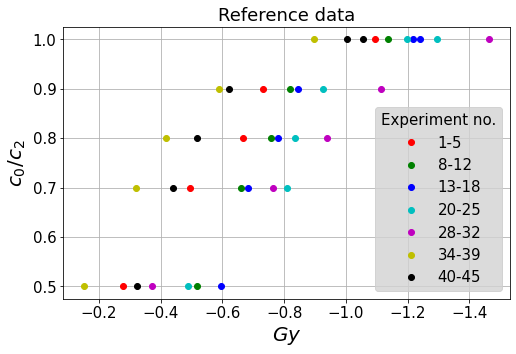

In [39]:
fig = plt.figure(figsize=(8, 5))
bx = fig.add_subplot(111)
bx.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title='Reference data')
#bx.axis([0,2,0,1])
bx.grid()

i = 0
for NLset in reference_data:
    bx.plot(NLset.G*(NLset.D/2-NLset.am), 1-NLset.lam, refcol[i]+'o', label=NLset.experiment.iloc[0]+'-'+NLset.experiment.iloc[-1])
    i += 1

bx.invert_xaxis()
bx.legend(title="Experiment no.", loc='lower right', facecolor='lightgray')
#plt.savefig('figures/reference_data.png', bbox_inches='tight')

For each dataset (e.g. D=3.1cm, Q=1,3,5,7 L/s) plot $c_0/c_2$ on the y-axis and $Gy$ on the x-axis, with:
$$\frac{c_0}{c_2} = 1-\lambda,$$
$$G = \frac{g'^{\frac{1}{3}}}{q^{\frac{2}{3}}},$$
$$y = P-h_0,$$
with the elevation of the outlet center $P=D/2$ and $h_0$ the height of the interface, which is either $h_r$ or $a_m$.\
This is done for one dataset in the figure below. A linear trend line can be fitted through the data points, giving the values of $a$ and $b$ of the equation from Fan, i.e. $c_0/c_2 = a - bGy$. In the case of $D=3.1$ cm and $Q=1$ L/s, this gives $a=0.27$ and $b=0.84$. But, we want to choose a constant $K$ beforehand, i.e. $K=0.53$ (this value of $K$ is chosen by using the model and calculating the concentrations, compare it with the observed values for different values of $K$. The value of $K$ where the computed values match the oberved values the best can now be chosen).

In [50]:
K = 0.53
b = 1/(2*K)

In [40]:
def transform(Gy, G, hL, P):
    return Gy + 2*G*(hL-P)

#simple linear fit function:
def f(x, slope, intercept):
    return slope*x + intercept

#linear fit function with fixed b
def func(x, a):
    return a - b*x

def linFit(x, y):
    """
    Linear fit through data.
    Returns:
    a: intercept
    b: slope
    r_value**2: R-squared
    p_value: P-value
    std_err: standard error
    """
    b, a, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return a, b, r_value**2, p_value, std_err

def fixedbFit(func, x, y):
    """
    Linear fit through data with a fixed value for the slope (b).
    Returns:
    a: intercept 
    r_squared: = R-squared
    """
    a = curve_fit(func, x, y)[0][0]
    residuals = y - func(x, *[a])
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return a, r_squared


def predband(x, xd, yd, p, func, conf=0.95):
    """
    x = requested points
    xd = x data
    yd = y data
    p = parameters
    func = function name
    conf = confidence level (default: 95%)
    """
    sig = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - sig / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

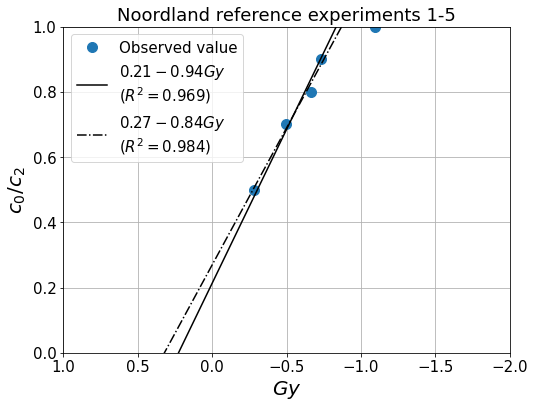

In [51]:
NL1204sel = reference_data[0] #NL1204sel is selected data set
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title=r"Noordland reference experiments {0}-{1}".format(NL1204sel.iloc[0].experiment, NL1204sel.iloc[-1].experiment))
ax.axis([-2,1,0,1])
ax.grid()
#don't include data points where lam=0 in the fit
lam0sel = np.where(NL1204sel.lam!=0)[0]
P = NL1204sel.iloc[0].D/2
G = pow(NL1204sel.rhofrac*9.81,1/3)/pow(NL1204sel.q,2/3)
y = NL1204sel.D/2 - NL1204sel.h0
Gy = G*y
c0c2 = 1 - NL1204sel.lam

Gyfit = np.linspace(-4,3,1000)

#fit keeping b fixed
a, rsq = fixedbFit(func, Gy.iloc[lam0sel], c0c2.iloc[lam0sel])
c0c2fit = a - b*Gyfit
hL = 1/(2*np.mean(G)*b)

#linear fit through datapoints
al, bl, rsql, pl, stdl = linFit(Gy.iloc[lam0sel], c0c2.iloc[lam0sel])
bl = abs(bl)
c0c2fitl = al - bl*Gyfit

ax.plot(Gy, c0c2, 'o', markersize=10, label="Observed value")
ax.plot(Gyfit, c0c2fit, 'k', label="${0:.2f}-{1:.2f}Gy$\n($R^2={2:.3f}$)".format(a,b,rsq))
ax.plot(Gyfit, c0c2fitl, '-.k', label="${0:.2f}-{1:.2f}Gy$\n($R^2={2:.3f}$)".format(al,bl,rsql))

# if P<hL: coordinate transform is needed
if P<hL:
    Gyp = transform(Gy, G, hL, P)
    ap = curve_fit(func, Gyp.iloc[lam0sel], c0c2.iloc[lam0sel])[0][0]
    c0c2fitp = ap - b*Gyfit
    coeffa.a[i] = ap
    coeffa.b[i] = b

    ax.plot(Gyp, c0c2, '^', markersize=10, label="Adjusted value")
    ax.plot(Gyfit, c0c2fitp, '--k', label="${0:.2f}-{1:.2f}Gy'$".format(ap,b))

ax.legend()
ax.invert_xaxis()
plt.show()

Now above is done for all reference experiment subsets and $P$, $h_L$, $a$ and $b$ are determined in and saved in 'coeffa'. Here, I don't plot every figure, because this is already done in another file.

In [52]:
#empty dataframe to fill in coefficient a and other values
coeffa = pd.DataFrame({'P':np.zeros(len(reference_data)),
                       'hL':np.zeros(len(reference_data)),
                       'a':np.zeros(len(reference_data)),
                       'b':np.zeros(len(reference_data))})

drsq = 0

K = 0.53
#create new directory for new K value:
Kdir = 'K='+str(K)
figpath = "figures/constant_K/using_am/{}/".format(Kdir)
try:
    os.mkdir(figpath)
    print("New directory created: '{}'".format(figpath))
except:
    print("Directory '{}' already exists".format(figpath))
    
b = 1/(2*K)

print("Creating linear fits through Noordland reference data")
i = 0 #counter
for NL1204sel in reference_data: #NL1204sel is selected data set
    #plt.clf()
    #fig = plt.figure(figsize=(8, 6))
    #ax = fig.add_subplot(111)
    #ax.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title=r"Noordland reference experiments {0}-{1}".format(NL1204sel.iloc[0].experiment, NL1204sel.iloc[-1].experiment))
    #ax.axis([-2,1,0,1])
    #ax.grid()
    #don't include data points where lam=0 in the fit
    lam0sel = np.where(NL1204sel.lam!=0)[0]
    P = NL1204sel.iloc[0].D/2
    G = pow(NL1204sel.rhofrac*9.81,1/3)/pow(NL1204sel.q,2/3)
    y = NL1204sel.D/2 - NL1204sel.h0
    Gy = G*y
    c0c2 = 1 - NL1204sel.lam

    Gyfit = np.linspace(-4,3,1000)

    #fit keeping b fixed
    a, rsq = fixedbFit(func, Gy.iloc[lam0sel], c0c2.iloc[lam0sel])
    c0c2fit = a - b*Gyfit
    hL = 1/(2*np.mean(G)*b)

    #linear fit through datapoints
    al, bl, rsql, pl, stdl = linFit(Gy.iloc[lam0sel], c0c2.iloc[lam0sel])
    bl = abs(bl)
    c0c2fitl = al - bl*Gyfit

    #ax.plot(Gy, c0c2, 'o', color=refcol[i], markersize=10, label="Observed value")
    #ax.plot(Gyfit, c0c2fit, 'k', label="${0:.2f}-{1:.2f}Gy$\n($R^2={2:.3f}$)".format(a,b,rsq))
    #ax.plot(Gyfit, c0c2fitl, '-.k', label="${0:.2f}-{1:.2f}Gy$\n($R^2={2:.3f}$)".format(al,bl,rsql))
    
    drsq += rsql - rsq
    
    coeffa.P[i] = P
    coeffa.hL[i] = hL
    coeffa.a[i] = a
    coeffa.b[i] = b
    
    if P<hL:
        Gyp = transform(Gy, G, hL, P)
        ap = curve_fit(func, Gyp.iloc[lam0sel], c0c2.iloc[lam0sel])[0][0]
        c0c2fitp = ap - b*Gyfit
        coeffa.a[i] = ap
        coeffa.b[i] = b

        #ax.plot(Gyp, c0c2, '^', color=refcol[i], markersize=10, label="Adjusted value")
        #ax.plot(Gyfit, c0c2fitp, '--k', label="${0:.2f}-{1:.2f}Gy'$".format(ap,b))

    #ax.legend()
    #ax.invert_xaxis()
    #plt.savefig(figpath+"{0}-{1}.pdf".format(NL1204sel.iloc[0].experiment, NL1204sel.iloc[-1].experiment))
    #plt.close()
    i += 1

Directory 'figures/constant_K/using_am/K=0.53/' already exists
Creating linear fits through Noordland reference data


The coefficient relationship $a$ versus $P/h_L-1$ can now be plotted:

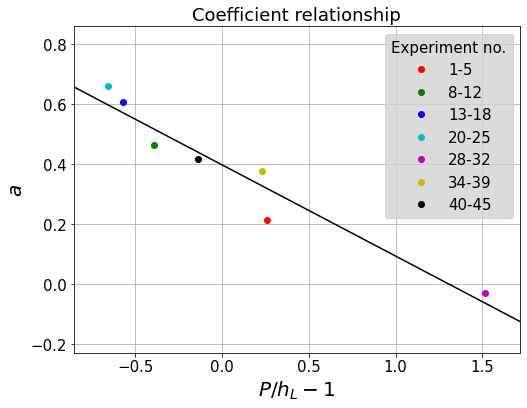

In [54]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set(xlabel=r"$P/h_L-1$", ylabel=r'$a$', title=r"Coefficient relationship".format(K))
ax.axis([min(coeffa.P/coeffa.hL-1)-0.2,max(coeffa.P/coeffa.hL-1)+0.2,
         min(coeffa.a)-0.2, max(coeffa.a)+0.2])
ax.grid()

xfit = np.linspace(-20,20,1000)
intercept, slope, r_squared, p_value, std_err = linFit(coeffa.P/coeffa.hL-1, coeffa.a)
afit = slope*xfit+intercept

## Exponential fit:
#def efunc(x, A, B, C):
#    return A * np.exp(-B * x) + C
#popt, pcov = curve_fit(efunc, coeffa.P/coeffa.hL-1, coeffa.a)
#afit = efunc(xfit, *popt)

[ax.plot(coeffa.P[i]/coeffa.hL[i]-1, coeffa.a[i], 'o', color=refcol[i], label=reference_data[i].experiment.iloc[0]+'-'+reference_data[i].experiment.iloc[-1]) for i in range(len(reference_data))]
ax.plot(xfit,afit,'k')

plt.legend(title=r"Experiment no.", loc='upper right', facecolor="lightgray")
plt.show()
#plt.savefig(figpath+"Coefficient relationship.pdf")

Comparing this to the relationship in Fan:

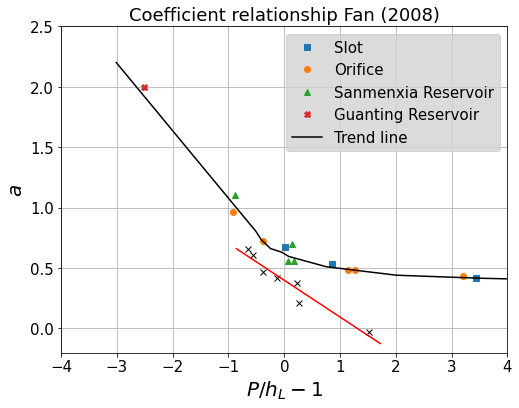

In [55]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set(xlabel=r"$P/h_L-1$", ylabel=r'$a$', title=r"Coefficient relationship Fan (2008)")
ax.axis([-4,4,-0.2,2.5])
ax.grid()

ax.plot(coeffaSlot.P/coeffaSlot.hL-1, coeffaSlot.a, 's', label=r"Slot")
ax.plot(coeffaOrifice.P/coeffaOrifice.hL-1, coeffaOrifice.a, 'o', label=r"Orifice")
ax.plot(coeffaSanmenxia.P/coeffaSanmenxia.hL-1, coeffaSanmenxia.a, '^', label=r"Sanmenxia Reservoir")
ax.plot(coeffaGuanting.P/coeffaGuanting.hL-1, coeffaGuanting.a, 'X', label=r"Guanting Reservoir")

ax.plot(coeffa.P/coeffa.hL-1, coeffa.a, 'xk')
p = np.polyfit(coeffa.P/coeffa.hL-1, coeffa.a, 1)
ax.plot(np.linspace(-0.86,1.72,2), p[0]*np.linspace(-0.86,1.72,2)+p[1],'r')

#trendline using webplotdigitizer
trendline_x = [-3.01123595505618, -0.5056179775280905, -0.41573033707865203, -0.24719101123595522,
               -0.0449438202247201, 0.0786516853932584, 0.7528089887640439, 2.011235955056179, 
               3.5168539325842687, 3.988764044943819]
sorttrend = np.argsort
trendline_y = [2.20066889632107, 0.8010033444816052, 0.7357859531772573, 0.6605351170568561,
               0.6304347826086956, 0.595317725752508, 0.5100334448160533, 0.43979933110367897, 
               0.4147157190635449, 0.40969899665551823]
ax.plot(trendline_x, trendline_y,'k', label="Trend line")

plt.legend(loc='upper right', facecolor="lightgray")
plt.show()

Now, the concentration ratio $c_0/c_2$ can be obtained using the steps described above.

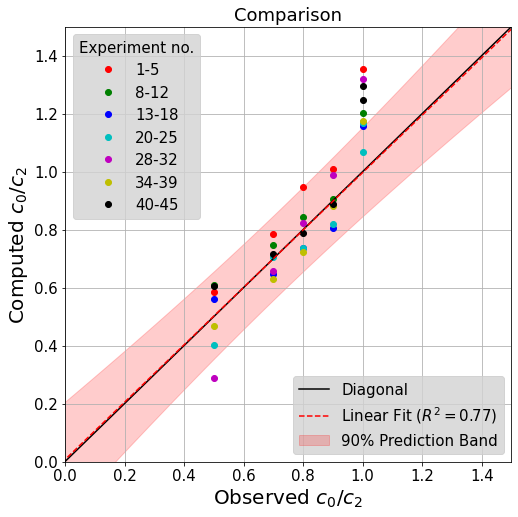

In [58]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set(xlabel=r"Observed $c_0/c_2$", ylabel=r'Computed $c_0/c_2$', title=r"Comparison".format(K))
ax.axis([0,1.5,0,1.5])
ax.grid()

c0c2comp_all = np.array([])
c0c2obs_all = np.array([])

i = 0
for NL1204sel in reference_data:
    #NL1204sel = NL1204ref

    c0c2obs = 1 - NL1204sel.lam
    G = pow(NL1204sel.rhofrac*9.81/NL1204sel.q**2,1/3)
    P = NL1204sel.D/2
    y = P - NL1204sel.h0

    hL = K/G
    acomp = np.interp(P/hL-1,xfit,afit)
    
    c0c2comp = acomp - b*G*y
    # if P<hL, the value of a from the graph is for y', so transformation back to y is needed:
    c0c2comp[P<=hL] = acomp[P<=hL] - b*G[P<=hL]*(y[P<=hL] + 2*(hL[P<=hL]-P[P<=hL]))
    # forcing c0/c2 to 0 or 1 when the computed value is <0 or >1, respectively:
    #c0c2comp[c0c2comp<0] = 0
    #c0c2comp[c0c2comp>1] = 1
    
    c0c2obs_all = np.append(c0c2obs_all, c0c2obs[c0c2obs<1])
    c0c2comp_all = np.append(c0c2comp_all, c0c2comp[c0c2obs<1])
    
    ax.plot(c0c2obs, c0c2comp, 'o', color=refcol[i], label=reference_data[i].experiment.iloc[0]+'-'+reference_data[i].experiment.iloc[-1])
    i+=1

c0c2comp_all[c0c2comp_all<0] = 0
c0c2comp_all[c0c2comp_all>1] = 1

lgd1 = plt.legend(title="Experiment no.", loc='upper left', facecolor='lightgray')

diagplot = ax.axline([1,1],slope=1, color='k', label='Diagonal')

# fit a curve to the data using a least squares 1st order polynomial fit
# from https://apmonitor.com/che263/index.php/Main/PythonRegressionStatistics
n = len(c0c2comp_all)
popt, pcov = curve_fit(f, c0c2obs_all, c0c2comp_all)
slope = popt[0]
intercept = popt[1]
r2 = 1.0-(sum((c0c2comp_all-f(c0c2obs_all,slope,intercept))**2)/((n-1.0)*np.var(c0c2comp_all,ddof=1)))
theta = np.arctan((slope-1)/(1+1*slope))/np.pi*180 #angle between fit and diagonal (in deg)
slope, intercept = unc.correlated_values(popt, pcov)

# calculate regression confidence interval
px = np.linspace(-2, 2, 100)
py = slope*px + intercept
nom = unp.nominal_values(py)
std = unp.std_devs(py)

lpb, upb = predband(px, c0c2obs_all, c0c2comp_all, popt, f, conf=0.9)

# plot the regression
regplot, = ax.plot(px, nom, '--r', label="Linear Fit ($R^2={0:.2f}$)".format(r2))

# uncertainty lines (90% confidence)
#ax.plot(px, nom - 1.96 * std, c='orange',label='90% Confidence Region')
#ax.plot(px, nom + 1.96 * std, c='orange')

#ax.plot(px, lpb, 'grey', linestyle='--', label='90% Prediction Band')
#ax.plot(px, upb, 'grey', linestyle='--')
predplot = ax.fill_between(px, lpb, upb, alpha=0.2, color='red', label="90% Prediction Band")

lgd2 = plt.legend([diagplot,regplot,predplot], [diagplot.get_label(),regplot.get_label(),predplot.get_label()],
                 facecolor='lightgrey', loc='lower right')
ax.add_artist(lgd1)

#plt.savefig(figpath+"comparison_plot.pdf")

Now, the concentrations can be calculated for the other experiments as well in the same way.